# 3. CKPlus CNN01+SVM+XGBoost 분류

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
import tensorflow as tf
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

import keras.backend.tensorflow_backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## 3.1. 학습에 사용될 하이퍼 패러미터 선언 및 Random Seed 설정

In [2]:
np.random.seed(201)

In [3]:
CKPLUS_DIR = "datasets/CK+48/prep/"
INPUT_TRAIN_DATA = 'CKPlus_X.npy'
LABEL_TRAIN_DATA = 'CKPlus_y.npy'

TEST_SPLIT = 0.2
RND_SEED = 0

In [4]:
input_data = np.load(open(CKPLUS_DIR + INPUT_TRAIN_DATA, 'rb'))
label_data = np.load(open(CKPLUS_DIR + LABEL_TRAIN_DATA, 'rb'))

In [5]:
input_shape = input_data[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (48, 48, 1)


In [6]:
x_train, x_val, y_train, y_val = train_test_split(input_data,
                                                  label_data,
                                                  test_size=TEST_SPLIT,
                                                  random_state=RND_SEED)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_train,
                                                    y_train,
                                                    test_size=TEST_SPLIT,
                                                    random_state=RND_SEED)

## 3.2 CNN모델 정의

In [8]:
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (5,5), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

In [9]:
def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

In [10]:
image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16)

x = fire_incept(x, fire=32, intercept=32)
x = fire_squeeze(x, fire=32, intercept=32)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = Conv2D(64, (3,3))(x)
x = LeakyReLU(alpha=0.1)(x)

x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)

out = Dense(2, activation='softmax')(x)

모델 컴파일

In [11]:
model = Model(image_input, out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 22, 22, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 22, 22, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 22, 22, 16)   2320        leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

모델 플롯 생성

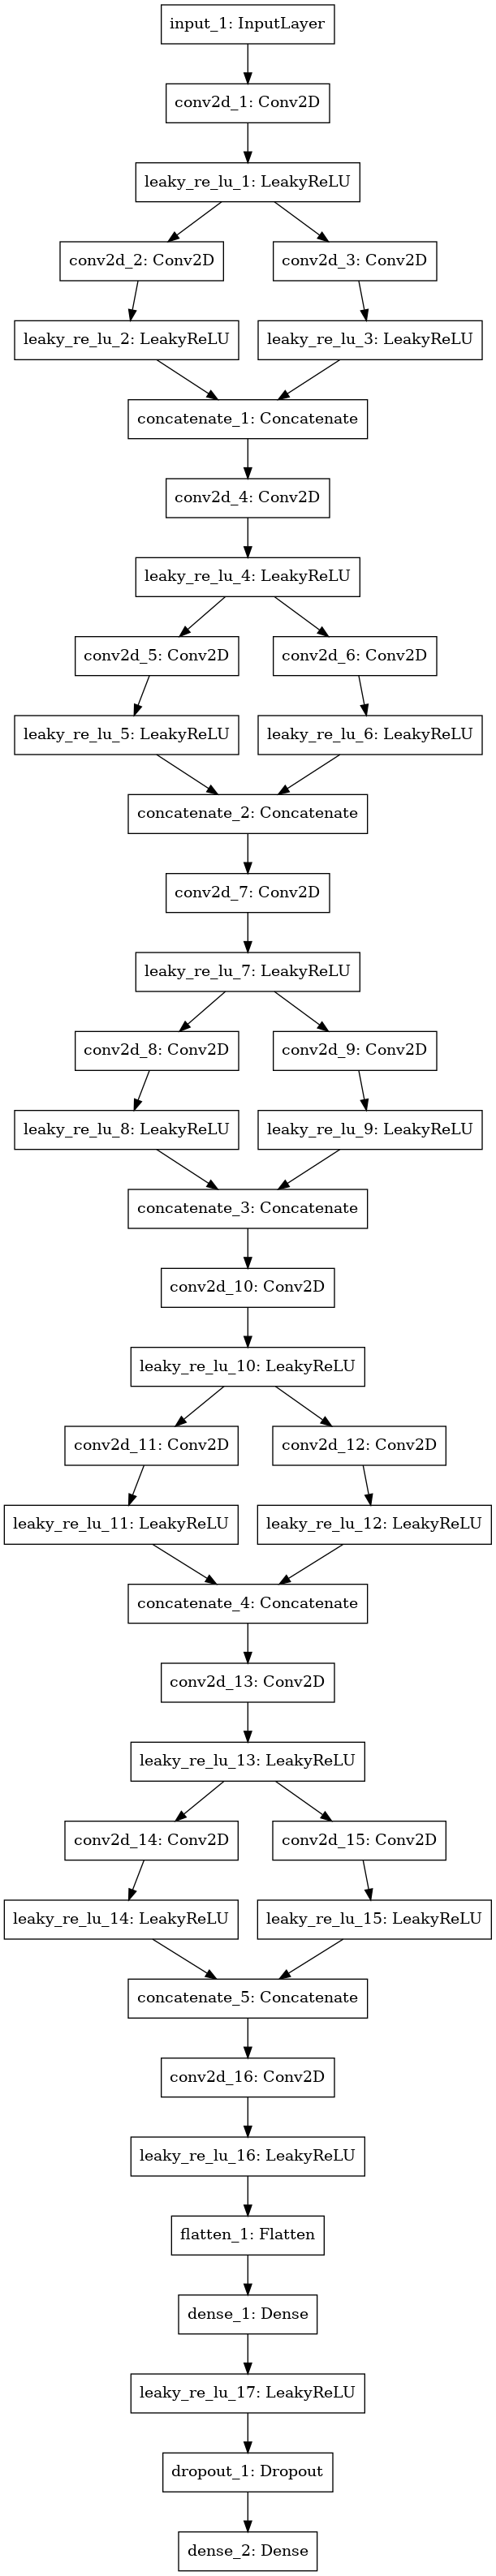

In [12]:
tf.keras.utils.plot_model(model, to_file='cnn/plot/CKPlus/model.png')

In [13]:
model.compile(optimizer = Adam(lr=.00025) , loss = 'binary_crossentropy', metrics=['accuracy'])

In [14]:
MODEL_PATH = 'cnn/weight/CKPlus/model_weights.h5f'

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
check_point = ModelCheckpoint(filepath=MODEL_PATH, monitor='val_accuracy', verbose=1, save_best_only=True)

## 3.3 CNN 모델 훈련

In [16]:
batch_size = 32
epochs = 40

In [17]:
# Training
with K.tf_ops.device('/device:GPU:0'):
    history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size,
                        validation_data = (x_val, y_val), callbacks=[learning_rate_reduction, check_point])

Train on 185 samples, validate on 59 samples
Epoch 1/40
185/185 [==============================] - 11s 57ms/step - loss: 0.6690 - accuracy: 0.7514 - val_loss: 0.6716 - val_accuracy: 0.5932

Epoch 00001: val_accuracy improved from -inf to 0.59322, saving model to cnn/weight/CKPlus/model_weights.h5f
Epoch 2/40
185/185 [==============================] - 0s 266us/step - loss: 0.5893 - accuracy: 0.7514 - val_loss: 0.6973 - val_accuracy: 0.5932

Epoch 00002: val_accuracy did not improve from 0.59322
Epoch 3/40
185/185 [==============================] - 0s 317us/step - loss: 0.5584 - accuracy: 0.7514 - val_loss: 0.6542 - val_accuracy: 0.5932

Epoch 00003: val_accuracy did not improve from 0.59322
Epoch 4/40
185/185 [==============================] - 0s 378us/step - loss: 0.4855 - accuracy: 0.7514 - val_loss: 0.5309 - val_accuracy: 0.5932

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00004: val_accuracy did not improve from 0.59322
Epoch 5/40
185/185 [

185/185 [==============================] - 0s 720us/step - loss: 5.2972e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000

Epoch 00038: val_accuracy did not improve from 1.00000
Epoch 39/40
185/185 [==============================] - 0s 297us/step - loss: 5.2136e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000

Epoch 00039: val_accuracy did not improve from 1.00000
Epoch 40/40
185/185 [==============================] - 0s 423us/step - loss: 4.4993e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000

Epoch 00040: val_accuracy did not improve from 1.00000


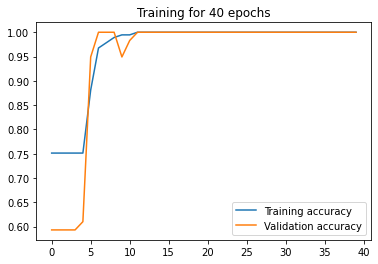

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

검증셋 정확도

In [19]:
model.load_weights(MODEL_PATH)
results = model.evaluate(x_val, y_val)
print('Test accuracy: ', results[1])

59/59 [==============================] - 0s 855us/step
Test accuracy:  1.0


## 3.4 SVM 적용

마지막 레이어에서 특징추출

In [20]:
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)

feat_train = model_feat.predict(x_train)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

feat_test = model_feat.predict(x_test)
print(feat_test.shape)

(185, 512)
(59, 512)
(47, 512)


SVM에 적용

In [21]:
svm = SVC(kernel='rbf')

svm.fit(feat_train, np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


훈련셋 정확도

In [22]:
svm.score(feat_train, np.argmax(y_train,axis=1))

0.9783783783783784

검증셋 정확도

In [23]:
svm.score(feat_val, np.argmax(y_val,axis=1))

0.9661016949152542

SVM의 Prediction 저장

In [24]:
prediction = svm.predict(feat_test)

## 3.5 XGBoost 적용

In [25]:
xb = xgb.XGBClassifier()

xb.fit(feat_train, np.argmax(y_train,axis=1))
print('fitting done !!!')

fitting done !!!


검증셋 정확도

In [26]:
xb.score(feat_val, np.argmax(y_val,axis=1))

0.9830508474576272

XGBoost의 Prediction 저장

In [27]:
prediction = xb.predict(feat_test)

최종 정확도 측정

In [28]:
xb.score(feat_test, np.argmax(y_test,axis=1))

1.0